In [2]:
import numpy as np
import sys
from tmp.Franke import SinglePathwayModel
from tmp.Franke import *
from tmp.Franke_feature import get_trace_features
import matplotlib.pyplot as plt
import os
import h5py

In [3]:
dt = 2

In [4]:
pre_step, stim, response = get_data_pair_lchirp(1, 20000, DATATYPE=1, dt=dt)

In [5]:
true_feature = get_trace_features(response, dt=dt)

In [6]:
true_feature.shape

(219,)

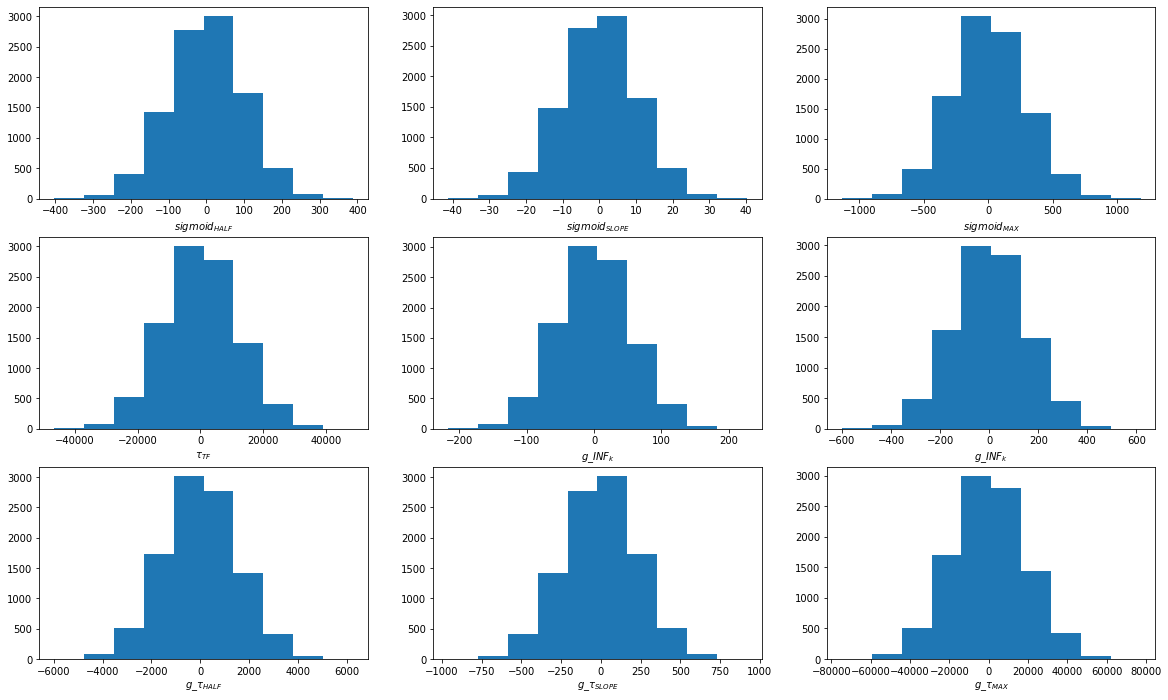

In [7]:
labels_params = [
            r'${sigmoid}_{HALF}$',
            r'${sigmoid}_{SLOPE}$',
            r'${sigmoid}_{MAX}$', r'$\tau_{TF}$',
            r'$g\_{INF}_k$', r'$g\_{INF}_k$',
            r'$g\_\tau_{HALF}$', r'$g\_\tau_{SLOPE}$',
            r'$g\_\tau_{MAX}$'
        ]

base_dir = 'Result/He/atomic_mog_10000/mog-round_3-n_train_10000'.format(1)
post_params_file = os.path.join(base_dir, 'param_samples.npy')

params = np.load(post_params_file)

fig = plt.figure(figsize=(20, 12))
for i in range(params.shape[-1]):
    plt.subplot(3, 3, i + 1)
    plt.hist(params[:, i])
    plt.xlabel(labels_params[i])
plt.savefig(os.path.join(base_dir, 'param_hist.png'), dpi=400)


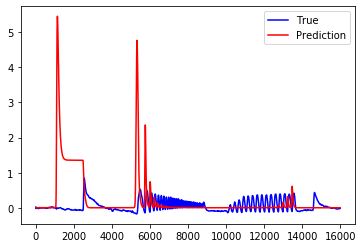

In [8]:
means_params = np.mean(params, axis=0)

model = SinglePathwayModel(means_params, dt=dt, single=True)
res = model.run(stim)[0][pre_step:]
feature = get_trace_features(res, dt=dt)

plt.plot(response, c='b', label='True')
plt.plot(res, c='r', label='Prediction')
plt.legend()
plt.savefig(os.path.join(base_dir, 'response_contrast.png'), dpi=400)


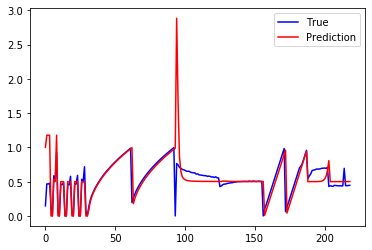

In [9]:
plt.plot(true_feature, c='b', label='True')
plt.plot(feature, c='r', label='Prediction')
plt.legend()
plt.savefig(os.path.join(base_dir, 'feature_contrast.png'), dpi=400)

In [ ]:
for i in range(3, 10):
    print("Processing {}".format(i))
    base_dir = './Result/exp_{}'.format(i)
    post_params_file = os.path.join(base_dir, 'posterior_samples.npy')
    
    params = np.load(post_params_file)

    fig = plt.figure(figsize=(20, 12))
    for i in range(params.shape[-1]):
        plt.subplot(3, 3, i + 1)
        plt.hist(params[:, i])
        plt.xlabel(labels_params[i])
    plt.savefig(os.path.join(base_dir, 'param_hist.png'), dpi=400)
    plt.clf()

    means_params = np.mean(params, axis=0)
    means_params

    model = SinglePathwayModel(means_params, dt=dt, single=True)
    res = model.run(stim)[0][pre_step:]
    feature = get_trace_features(res, dt=dt)

    plt.plot(response, c='b', label='True')
    plt.plot(res, c='r', label='Prediction')
    plt.legend()
    plt.savefig(os.path.join(base_dir, 'response_contrast.png'), dpi=400)
    plt.clf()

    plt.plot(true_feature, c='b', label='True')
    plt.plot(feature, c='r', label='Prediction')
    plt.legend()
    plt.savefig(os.path.join(base_dir, 'feature_contrast.png'), dpi=400)
    plt.clf()


In [11]:
param_ranges = [np.array([[0.5, 4]]),  # half of sigmoid
     np.array([[0.1, 3]]), # slope of sigmoid
     np.array([[0.1, 5]]), # maximum of sigmoid
     np.array([[0.1, 50]]), # tau fo temporal filter
     np.array([[0.01, 2]]), # k of gain infi
     np.array([[0.2, 3]]), # m of gain infi
     np.array([[-2, +2]]), # half of gain tau
     np.array([[-1, +1]]), # slope of gain tau
     np.array([[100, 1500]])] # max of gain tau

In [ ]:
_iter = int(5000)
res_list = list()
param_list = list()
for _ in range(_iter):
    print("Processing {}".format(_), end='\r')
    params = list()
    for param_range in param_ranges:
        theta = np.random.uniform(*param_range[0])
        params.append(theta)
    model = SinglePathwayModel(params, dt=dt, single=True)
    res = model.run(stim)[0][pre_step:]
    param_list.append(params)
    res_list.append(res)

In [ ]:
res_array = np.array(res_list)
res_array.shape

In [12]:
base_dir = './Data/Curve_data'
data_file = h5py.File(os.path.join(base_dir, "Ribon_curve_0.h5"), 'r')
data_file.keys()

param_data = data_file.get('param_data')[...]
stats_data = data_file.get('stats_data')[...]

for i in range(1, 5):
    with h5py.File(os.path.join(base_dir, "Ribon_curve_{}.h5".format(i)), 'r') as data_file:
        sub_param_data = data_file.get('param_data')[...]
        sub_stats_data = data_file.get('stats_data')[...]
        param_data = np.concatenate((param_data, sub_param_data), axis=0)
        stats_data = np.concatenate((stats_data, sub_stats_data), axis=0)

<KeysViewHDF5 ['param_data', 'stats_data']>

In [15]:
stats_data.shape

(10000, 15996)

In [16]:
param_data.shape

(10000, 9)

In [51]:
new_file = h5py.File(os.path.join(base_dir, 'TimeContrastive.h5'), 'w')

In [21]:
time_contrastive_data = np.zeros((10000 * 3, 15996 // 3))
time_contrastive_label = np.zeros((10000 * 3, 1))

In [22]:
for i in range(3):
    time_contrastive_data[i*10000:(i+1)*10000, :] = stats_data[:, i*5332:(i+1)*5332]
    time_contrastive_label[i*10000:(i+1)*10000, :] = np.ones((10000, 1)) * i

In [43]:
time_contrastive_data = time_contrastive_data.reshape(10000 * 3, 1, 15996//3).astype(np.float32)
time_contrastive_label = time_contrastive_label.reshape(10000 * 3).astype(np.int64)

In [47]:
import random
sample_ID = list(range(10000 * 3))
random.shuffle(sample_ID)

In [48]:
time_contrastive_data = time_contrastive_data[sample_ID]
time_contrastive_data.shape

(30000, 1, 5332)

In [49]:
time_contrastive_label = time_contrastive_label[sample_ID]
time_contrastive_label.shape

(30000,)

In [52]:
new_file.create_dataset('trace', data=time_contrastive_data)
new_file.create_dataset('label', data=time_contrastive_label)

<HDF5 dataset "label": shape (30000,), type "<i8">

In [53]:
new_file.close()

In [ ]:
stats_data_list = [stats_data[:5000, :5000], stats_data[:5000, 5000:10000], stats_data[:5000, 10000:]]

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca_list = [PCA(n_components=25), PCA(n_components=25), PCA(n_components=25)]

In [ ]:
for i in range(3):
    pca_list[i].fit(stats_data_list[i])

In [ ]:
for i in range(3):
    np.save("PCA_{}.npy".format(i), pca_list[i].components_)

In [ ]:
x_list = list()
for i in range(int(1e4)):
    x = np.random.random(response.shape)
    x_list.append(x)
    get_trace_features(x, dt=dt).shape

In [ ]:
x = np.concatenate(x_list)

In [ ]:
x_list[12]

In [ ]:
feature_x = get_trace_features(x_list[12], dt=dt)
feature_x.shape

In [ ]:
feature_x

In [ ]:
plt.plot(x * 100)

In [ ]:
np.save('wrong_trace.npy', x)

In [ ]:
response.shape

In [ ]:
pre_step

In [ ]:
plt.plot(stim, c='b')

In [ ]:
plt.plot(response, c='r')

In [ ]:
model = SinglePathwayModel(np.random.random((9)), dt=dt, single=True)

In [ ]:
random_response = model.run(stim)

In [ ]:
from delfi.simulator.BaseSimulator import BaseSimulator

class Ribon(BaseSimulator):
    def __init__(self, I, dt, dim_param, pre_step, Model, seed=None):
        """Ribon simulator

        Parameters
        ----------
        I : array
            Numpy array with the input current
        dt : float
            Timestep
        dim_param : int
            Number of parameter
        pre_step : int
            Number of time points before the stimuli
        seed : int or None
            If set, randomness across runs is disabled
        """

        super().__init__(dim_param=dim_param, seed=seed)
        self.I = I
        self.dt = dt
        self.t = np.arange(0, len(self.I), 1)*self.dt
        self.RibonModel = Model
        self.pre_step = pre_step

    def gen_single(self, params):
        """Forward model for simulator for single parameter set

        Parameters
        ----------
        params : list or np.array, 1d of length dim_param
            Parameter vector

        Returns
        -------
        dict : dictionary with data
            The dictionary must contain a key data that contains the results of
            the forward run. Additional entries can be present.
        """
        params = np.asarray(params)

        assert params.ndim == 1, 'params.ndim must be 1'

        hh_seed = self.gen_newseed()

        model = self.RibonModel(params, dt=self.dt, single=True)
        states = model.run(self.I)[0][pre_step:]

        return {'data': states.reshape(-1),
                'time': self.t,
                'dt': self.dt,
                'I': self.I}

In [ ]:
param_dim = 9
RibonSimulator = Ribon(stim, dt, param_dim, pre_step, SinglePathwayModel)

In [ ]:
data = RibonSimulator.gen_single(np.random.random((9)))

In [ ]:
plt.plot(data['data'])

In [ ]:
from delfi.summarystats.BaseSummaryStats import BaseSummaryStats
from scipy import stats as spstats

class RibonStats(BaseSummaryStats):
    """Moment based SummaryStats class for the Ribon model

    Calculates summary statistics
    """
    def __init__(self, t_on, t_off, dt, n_summary, seed=None):
        """See SummaryStats.py for docstring"""
        super(RibonStats, self).__init__(seed=seed)
        self.t_on = t_on
        self.t_off = t_off
        self.dt = dt
        self.n_summary = n_summary

    def calc(self, repetition_list):
        """Calculate summary statistics

        Parameters
        ----------
        repetition_list : list of dictionaries, one per repetition
            data list, returned by `gen` method of Simulator instance

        Returns
        -------
        np.array, 2d with n_reps x n_summary
        """
        stats = []
        for r in range(len(repetition_list)):
            x = repetition_list[r]
            # sum_stats_vec = get_trace_features(x['data'], self.dt)
            sum_stats_vec = x['data']
            stats.append(sum_stats_vec)

        return np.asarray(stats)

In [ ]:
x = [np.array([[0.5, 4]]),  # half of sigmoid
     np.array([[0.1, 3]]), # slope of sigmoid
     np.array([[0.1, 5]]), # maximum of sigmoid
     np.array([[0.1, 50]]), # tau fo temporal filter
     np.array([[0.01, 2]]), # k of gain infi
     np.array([[0.2, 3]]), # m of gain infi
     np.array([[-2, +2]]), # half of gain tau
     np.array([[-1, +1]]), # slope of gain tau
     np.array([[100, 1500]])] # max of gain tau

In [ ]:
import delfi.distribution as dd

seed_p = 2
prior_min = np.concatenate(x, axis=0)[:, 0]
prior_max = np.concatenate(x, axis=0)[:, 1]
prior = dd.Uniform(lower=prior_min, upper=prior_max,seed=seed_p)

In [ ]:
import delfi.generator as dg

# input current, time step
t_on = 0
t_off = len(stim)

# seeds
seed_m = 1

# summary statistics hyperparameters
n_summary = 218

# define model, prior, summary statistics and generator classes
s = RibonStats(t_on=t_on, t_off=t_off, dt=dt, n_summary=n_summary)

n_processes = 5

seeds_m = np.arange(1, n_processes+1, 1)
m = []
for i in range(n_processes):
    m.append(Ribon(stim, dt, param_dim, pre_step, SinglePathwayModel, seed=seeds_m[i]))
g = dg.MPGenerator(models=m, prior=prior, summary=s)

In [ ]:
seed_inf = 1

pilot_samples = 10

# training schedule
n_train = 10
n_rounds = 1

# fitting setup
minibatch = 10
epochs = 10
val_frac = 0.05

# network setup
n_hiddens = [50,50]

# convenience
prior_norm = True

# MAF parameters
density = 'maf'
n_mades = 5         # number of MADES

In [ ]:
import delfi.inference as infer

# inference object
res = infer.SNPEC(g,
                obs=response,
                n_hiddens=n_hiddens,
                seed=seed_inf,
                pilot_samples=pilot_samples,
                n_mades=n_mades,
                prior_norm=prior_norm,
                density=density)

In [ ]:
# train
log, _, posterior = res.run(
                    n_train=n_train,
                    n_rounds=n_rounds,
                    minibatch=minibatch,
                    epochs=epochs,
                    silent_fail=False,
                    proposal='prior',
                    val_frac=val_frac,
                    verbose=True,)

In [ ]:
import delfi

In [ ]:
dir(delfi.)

In [ ]:
log

In [ ]:
fig = plt.figure(figsize=(15,5))

plt.plot(log[0]['loss'],lw=2)
plt.xlabel('iteration')
plt.ylabel('loss');

In [ ]:
from delfi.utils.viz import samples_nd

prior_min = g.prior.lower
prior_max = g.prior.upper
prior_lims = np.concatenate((prior_min.reshape(-1,1),prior_max.reshape(-1,1)),axis=1)

posterior_samples = posterior[0].gen(10000)

###################
# colors
hex2rgb = lambda h: tuple(int(h[i:i+2], 16) for i in (0, 2, 4))

# RGB colors in [0, 255]
col = {}
col['GT']      = hex2rgb('30C05D')
col['SNPE']    = hex2rgb('2E7FE8')
col['SAMPLE1'] = hex2rgb('8D62BC')
col['SAMPLE2'] = hex2rgb('AF99EF')

# convert to RGB colors in [0, 1]
for k, v in col.items():
    col[k] = tuple([i/255 for i in v])

labels_params = [ str(i) for i in range(9)]
###################
# posterior
fig, axes = samples_nd(posterior_samples,
                       limits=prior_lims,
                       ticks=prior_lims,
                       labels=labels_params,
                       fig_size=(5,5),
                       diag='kde',
                       upper='kde',
                       hist_diag={'bins': 50},
                       hist_offdiag={'bins': 50},
                       kde_diag={'bins': 50, 'color': col['SNPE']},
                       kde_offdiag={'bins': 50},
                       # points=[true_params],
                       points_offdiag={'markersize': 5},
                       points_colors=[col['GT']],
                       title='');


